In [2]:
import pandas as pd 
import numpy as np 
import math as math
import joblib
from joblib import dump
import os
import time

## DATA TEST

In [1]:
def load_Dataset(baseFile, fold_Number): 
    rnmColData = ['user_id', 'item_id', 'rating', 'timestamp']
    test_File = f"{baseFile}/u{fold_Number}.test"
    test_Data = pd.read_csv(test_File, sep="\t", header=None, names=rnmColData)
    test_Data = test_Data.drop(columns=["timestamp"])
    return test_Data

In [135]:
call_base = "../ml-100k"
testdata = load_Dataset(call_base, 4)
testdata


,user_id,item_id,rating
0,1,4,3
1,1,7,4
2,1,42,5
3,1,43,4
4,1,55,5
...,...,...,...
19995,943,943,5
19996,943,1011,2
19997,943,1067,2
19998,943,1074,4


In [89]:
def GetUniqueUserItemShape(ratingData, fold_num=1):
    max_user = ratingData['user_id'].max()
    unique_user_count = ratingData['user_id'].nunique()
    unique_item_count = ratingData['item_id'].nunique()
    result = f"fold {fold_num} {unique_user_count},{unique_item_count}"
    return result

# Loop untuk fold 1 sampai 5
for fold in range(1, 6):
    testdata = load_Dataset(call_base, fold)
    output = GetUniqueUserItemShape(testdata, fold)
    print(output)


fold 1 459,1410
fold 2 653,1420
fold 3 869,1423
fold 4 923,1394
fold 5 927,1407


In [20]:
cal = len(pd.unique(testdata["user_id"])-1)
cal


459

In [126]:
def get_user_item_list(ratingData):
    unique_users = sorted(ratingData['user_id'].unique())
    unique_items = sorted(ratingData['item_id'].unique())

    # Grup item_id per user_id jadi list item (ground truth)
    grouped = ratingData.groupby('user_id')['item_id'].apply(list)

    # Buat list groundTruth (list item per user) sesuai urutan unique_users
    groundTruth = [grouped[user] for user in unique_users]

    return groundTruth


In [136]:
gt2 = get_user_item_list(testdata)
print(len(gt2))

923


In [131]:
# calTest = ConvertRatingMatriks(testdata)
# calTest

In [132]:
# def ConvertGTtoList(gt_df):
#     groundTruth = []
#     # Iterasi untuk setiap user_id di dalam gt_df
#     for user_id in gt_df.index:
#         # Ambil semua rating user tersebut (baris)
#         user_ratings = gt_df.loc[user_id]
#         # Ambil item_id yang punya rating > 0 (relevan), ambil nama item koncert ke list
#         relevant_items = user_ratings[user_ratings > 0].index.astype(float).tolist()
#         # tambahkan ke dalam list groundTruth
#         groundTruth.append(relevant_items)
#     return groundTruth

In [ ]:
# rating_Matriks = ConvertRatingMatriks(testdata)
# print(rating_Matriks.shape)
# # rating_Matriks

# # dataset 
# allItem = rating_Matriks.columns
# alluser = rating_Matriks.index
# print(f"all item {len(allItem)}")
# itemRated = set(rating_Matriks.columns[rating_Matriks.sum(axis=0) > 0])
# print(f"item rated {len(itemRated)}")
# userRated = set(rating_Matriks.index[rating_Matriks.sum(axis=1) > 0])
# print(f"user rated2 {len(userRated)}")

# # item yang tidak pernah di rating
# itemNotRated = set(allItem) - itemRated
# print(f"item not rated {len(itemNotRated)}")
# itemNotRated2 = set(alluser) - userRated
# print(f"user not rated2 {len(itemNotRated2)}")

(459, 1410)
all item 1410
item rated 1323
user rated2 457
item not rated 87
user not rated2 2


In [43]:
# toy data ndcg
groundTruthFold1 = [[1, 2, 3, 4, 11], [1, 12, 4, 7], [4, 11, 12, 32], [2, 3, 5, 10]]
groundTruthFold2 = [[3, 5, 7, 10, 11], [2, 3, 5, 11], [1, 10, 11, 12], [4, 7, 12, 21]]
TopNrekFold1 = [[1, 5, 2, 3, 15], [1,4,6,2], [11, 4, 32, 1], [2, 4, 10, 45]]
TopNrekFold2 = [[2, 3, 4, 15, 5], [3,2,12,42], [1, 12, 2, 22], [4, 7, 12, 22]]


In [44]:
groundTruth1 = [1, 2, 3, 4]
TopNrek1 = [1, 5, 2, 3, 15]

In [12]:
print(TopNrek1[:3])
print(TopNrek1[:3][-1] in groundTruth1)

[1, 5, 2]
True


## DCG


$$  DCG(GT_u, TopN_u, N) = \sum_{n=1}^{N} \frac{1}{log_2(1+n)}  \cdot \parallel (TopN_u(n) \in  GT_u) $$

In [45]:
# dcg per user
def EvaluasiDCG(groundTruth, TopNRekomendasi, N):
    """
    Fungsi untuk menghitung DCG (Discounted Cumulative Gain) untuk rekomendasi item
    """
    rumusIDCG = np.array([(1 / np.log2( 1 + x)) for x in range(1, N+1)])
    cekGT = np.array([1 if tp in groundTruth else 0 for tp in TopNRekomendasi[:N]])
    return np.sum(rumusIDCG* cekGT)

In [14]:
# def dcgN(groundTruth, TopNrek, N):
#     totalDCG = 0
#     for i in range(len(groundTruth)):
#         dcgN = EvaluasiDCG(groundTruth[i], TopNrek[i], N)
#         totalDCG += dcgN
#         print(f"DCG untuk user ke-{i+1}: {dcgN}")
#     avgDCG = totalDCG / len(groundTruth)
#     # avgDCG = totalDCG
#     print(f"\nRata-rata DCG: {avgDCG}")
#     return avgDCG

In [46]:
import pandas as pd

def dcgN2(groundTruth, TopNrek, max_N):
    dcg_matrix = []  # Menyimpan DCG tiap user untuk N = 1 sampai max_N

    for i in range(len(groundTruth)):
        user_dcg = []
        print(f"\nUser ke-{i+1}:")
        for N in range(1, max_N + 1):
            dcg_value = EvaluasiDCG(groundTruth[i], TopNrek[i], N)
            user_dcg.append(dcg_value)
            print(f"  DCG@{N}: {dcg_value}")
        dcg_matrix.append(user_dcg)

    # Buat DataFrame
    columns = [f"DCG@{N}" for N in range(1, max_N + 1)]
    df_dcg = pd.DataFrame(dcg_matrix, columns=columns)
    df_dcg.index = [f"User-{i+1}" for i in range(len(groundTruth))]

    # Tambahkan rata-rata DCG@N
    avg_row = df_dcg.mean()
    df_dcg.loc["Rata-rata"] = avg_row

    # print("\nDataFrame DCG per user:")
    # print(df_dcg)

    return df_dcg


In [16]:

calDCGN = dcgN2(groundTruthFold1, TopNrekFold1, 4)
calDCGN


User ke-1:
  DCG@1: 1.0
  DCG@2: 1.0
  DCG@3: 1.5
  DCG@4: 1.9306765580733931

User ke-2:
  DCG@1: 1.0
  DCG@2: 1.6309297535714575
  DCG@3: 1.6309297535714575
  DCG@4: 1.6309297535714575

User ke-3:
  DCG@1: 1.0
  DCG@2: 1.6309297535714575
  DCG@3: 2.1309297535714578
  DCG@4: 2.1309297535714578

User ke-4:
  DCG@1: 1.0
  DCG@2: 1.0
  DCG@3: 1.5
  DCG@4: 1.5


,DCG@1,DCG@2,DCG@3,DCG@4
User-1,1.0,1.000000,1.500000,1.930677
User-2,1.0,1.630930,1.630930,1.630930
User-3,1.0,1.630930,2.130930,2.130930
User-4,1.0,1.000000,1.500000,1.500000
Rata-rata,1.0,1.315465,1.690465,1.798134


In [17]:
# list_gt = [groundTruthFold1, groundTruthFold2]
# list_top = [TopNrekFold1, TopNrekFold2]

# all_df = []

# for gt, top in zip(list_gt, list_top):
#     df = dcgN2(gt, top, max_N=4)
#     df_clean = df.drop("Rata-rata")
#     all_df.append(df_clean)

# df_all = pd.concat(all_df)
# avg_all_folds = df_all.mean().to_frame().T
# avg_all_folds.index = ["Rata-rata Semua Fold"]

# df_final = pd.concat([df_all, avg_all_folds])
# print(df_final)


In [18]:
dfFold1 = dcgN2(groundTruthFold1, TopNrekFold1, 4)
dfFold2 =  dcgN2(groundTruthFold2, TopNrekFold2, 4)

# hapus baris rata-rata
dfCleanRata1 = dfFold1.drop('Rata-rata')
dfCleanRata2 = dfFold2.drop('Rata-rata')

# gabungkan semua user dari semua fold

df_all = pd.concat([dfCleanRata1, dfCleanRata2])

# hitung rata-rata seluruh fold
rata2fold = df_all.mean().to_frame().T
rata2fold.index = ["rata-rata semua fold"]

dfFinalFold = pd.concat([df_all, rata2fold])
dfFinalFold


User ke-1:
  DCG@1: 1.0
  DCG@2: 1.0
  DCG@3: 1.5
  DCG@4: 1.9306765580733931

User ke-2:
  DCG@1: 1.0
  DCG@2: 1.6309297535714575
  DCG@3: 1.6309297535714575
  DCG@4: 1.6309297535714575

User ke-3:
  DCG@1: 1.0
  DCG@2: 1.6309297535714575
  DCG@3: 2.1309297535714578
  DCG@4: 2.1309297535714578

User ke-4:
  DCG@1: 1.0
  DCG@2: 1.0
  DCG@3: 1.5
  DCG@4: 1.5

User ke-1:
  DCG@1: 0.0
  DCG@2: 0.6309297535714575
  DCG@3: 0.6309297535714575
  DCG@4: 0.6309297535714575

User ke-2:
  DCG@1: 1.0
  DCG@2: 1.6309297535714575
  DCG@3: 1.6309297535714575
  DCG@4: 1.6309297535714575

User ke-3:
  DCG@1: 1.0
  DCG@2: 1.6309297535714575
  DCG@3: 1.6309297535714575
  DCG@4: 1.6309297535714575

User ke-4:
  DCG@1: 1.0
  DCG@2: 1.6309297535714575
  DCG@3: 2.1309297535714578
  DCG@4: 2.1309297535714578


,DCG@1,DCG@2,DCG@3,DCG@4
User-1,1.000,1.000000,1.500000,1.930677
User-2,1.000,1.630930,1.630930,1.630930
User-3,1.000,1.630930,2.130930,2.130930
User-4,1.000,1.000000,1.500000,1.500000
User-1,0.000,0.630930,0.630930,0.630930
User-2,1.000,1.630930,1.630930,1.630930
User-3,1.000,1.630930,1.630930,1.630930
User-4,1.000,1.630930,2.130930,2.130930
rata-rata semua fold,0.875,1.348197,1.598197,1.652032


In [19]:
calDCG = EvaluasiDCG(groundTruth1, TopNrek1, 5)
calDCG

1.9306765580733931

## IDCG


$$ IDCG(N) = \sum_{n=1}^{N} \frac{1}{log_2(1+n)}  $$

In [47]:
def IdealDCG(N):
    """
    Fungsi untuk menghitung IDCG (Ideal Discounted Cumulative Gain) untuk rekomendasi item
    """
    rumusIDCG = np.sum(np.array([(1 / np.log2( 1 + x)) for x in range(1, N+1)]))
    # print(rumusIDCG)
    return rumusIDCG

In [21]:
calIdcf = IdealDCG(20)
calIdcf

7.040268381923513

## NDCG

$$ NDCG(GT_u, TopN_u, N) = \frac {DCG(GT_u, TopN_u, N)}{IDCG(N)} $$ 

In [48]:
def EvaluasiNDCG(groundTruth, TopNRekomendasi, N):
    """
    Fungsi untuk menghitung NDCG (Normalized Discounted Cumulative Gain) untuk rekomendasi item
    """
    evaluasiNDCG = EvaluasiDCG(groundTruth, TopNRekomendasi, N) / IdealDCG(N)
    return evaluasiNDCG

In [23]:
# def ndcgN(groundTruth, TopNrek, N):
#     totalNDCG = 0
#     for i in range(len(groundTruth)):
#         ndcgN = EvaluasiNDCG(groundTruth[i], TopNrek[i], N)
#         totalNDCG += ndcgN
#         print(f"nDCG untuk data ke-{i+1}: {ndcgN}")
#     avgNDCG = totalNDCG / len(groundTruth)
#     print(f"\nRata-rata NDCG: {avgNDCG}")
#     return avgNDCG

In [49]:
def NDCGN(groundTruth, TopNrek, max_N):
    ndcg_matrix = []  # Menyimpan DCG tiap user untuk N = 1 sampai max_N

    for i in range(len(groundTruth)):
        user_ndcg = []
        print(f"\nUser ke-{i+1}:")
        for N in range(1, max_N + 1):
            ndcg_value = EvaluasiNDCG(groundTruth[i], TopNrek[i], N)
            user_ndcg.append(ndcg_value)
            print(f"  NDCG@{N}: {ndcg_value}")
        ndcg_matrix.append(user_ndcg)

    # Buat DataFrame
    columns = [f"NDCG@{N}" for N in range(1, max_N + 1)]
    df_ndcg = pd.DataFrame(ndcg_matrix, columns=columns)
    df_ndcg.index = [f"User-{i+1}" for i in range(len(groundTruth))]

    # Tambahkan rata-rata DCG@N
    avg_row = df_ndcg.mean()
    df_ndcg.loc["Rata-rata"] = avg_row

    # print("\nDataFrame DCG per user:")
    # print(df_dcg)

    return df_ndcg


In [25]:
calNDCGN = NDCGN(groundTruthFold1, TopNrekFold1, 4)
calNDCGN


User ke-1:
  NDCG@1: 1.0
  NDCG@2: 0.6131471927654584
  NDCG@3: 0.7039180890341347
  NDCG@4: 0.75369761125927

User ke-2:
  NDCG@1: 1.0
  NDCG@2: 1.0
  NDCG@3: 0.7653606369886217
  NDCG@4: 0.6366824387328317

User ke-3:
  NDCG@1: 1.0
  NDCG@2: 1.0
  NDCG@3: 1.0
  NDCG@4: 0.8318724637288826

User ke-4:
  NDCG@1: 1.0
  NDCG@2: 0.6131471927654584
  NDCG@3: 0.7039180890341347
  NDCG@4: 0.5855700749881525


,NDCG@1,NDCG@2,NDCG@3,NDCG@4
User-1,1.0,0.613147,0.703918,0.753698
User-2,1.0,1.000000,0.765361,0.636682
User-3,1.0,1.000000,1.000000,0.831872
User-4,1.0,0.613147,0.703918,0.585570
Rata-rata,1.0,0.806574,0.793299,0.701956


In [26]:
dfFold1 = NDCGN(groundTruthFold1, TopNrekFold1, 4)
dfFold2 =  NDCGN(groundTruthFold2, TopNrekFold2, 4)

# hapus baris rata-rata
dfCleanRata1 = dfFold1.drop('Rata-rata')
dfCleanRata2 = dfFold2.drop('Rata-rata')

# gabungkan semua user dari semua fold

df_all = pd.concat([dfCleanRata1, dfCleanRata2])

# hitung rata-rata seluruh fold
rata2fold = df_all.mean().to_frame().T
rata2fold.index = ["rata-rata semua fold"]

dfFinalFold = pd.concat([df_all, rata2fold])
dfFinalFold


User ke-1:
  NDCG@1: 1.0
  NDCG@2: 0.6131471927654584
  NDCG@3: 0.7039180890341347
  NDCG@4: 0.75369761125927

User ke-2:
  NDCG@1: 1.0
  NDCG@2: 1.0
  NDCG@3: 0.7653606369886217
  NDCG@4: 0.6366824387328317

User ke-3:
  NDCG@1: 1.0
  NDCG@2: 1.0
  NDCG@3: 1.0
  NDCG@4: 0.8318724637288826

User ke-4:
  NDCG@1: 1.0
  NDCG@2: 0.6131471927654584
  NDCG@3: 0.7039180890341347
  NDCG@4: 0.5855700749881525

User ke-1:
  NDCG@1: 0.0
  NDCG@2: 0.38685280723454163
  NDCG@3: 0.2960819109658652
  NDCG@4: 0.24630238874073

User ke-2:
  NDCG@1: 1.0
  NDCG@2: 1.0
  NDCG@3: 0.7653606369886217
  NDCG@4: 0.6366824387328317

User ke-3:
  NDCG@1: 1.0
  NDCG@2: 1.0
  NDCG@3: 0.7653606369886217
  NDCG@4: 0.6366824387328317

User ke-4:
  NDCG@1: 1.0
  NDCG@2: 1.0
  NDCG@3: 1.0
  NDCG@4: 0.8318724637288826


,NDCG@1,NDCG@2,NDCG@3,NDCG@4
User-1,1.000,0.613147,0.703918,0.753698
User-2,1.000,1.000000,0.765361,0.636682
User-3,1.000,1.000000,1.000000,0.831872
User-4,1.000,0.613147,0.703918,0.585570
User-1,0.000,0.386853,0.296082,0.246302
User-2,1.000,1.000000,0.765361,0.636682
User-3,1.000,1.000000,0.765361,0.636682
User-4,1.000,1.000000,1.000000,0.831872
rata-rata semua fold,0.875,0.826643,0.750000,0.644920


In [27]:
calNDCG = EvaluasiNDCG(groundTruth1, TopNrek1, 4)
calNDCG

0.75369761125927

## LOPP TEST REAL DATA

In [109]:
openTopN = joblib.load("../case/topN/Jac/topNUser/2/5_20_0.7.joblib")

# jadikan data frame
print((openTopN))

[[1535, 813, 1511, 1499, 1466, 1598, 1448, 1449, 1063, 1652, 1641, 1366, 407, 1462, 267, 88, 1121, 1188, 317, 284], [1535, 813, 1511, 1598, 1466, 1652, 1499, 1449, 1292, 63, 922, 1063, 1448, 1641, 317, 1121, 1188, 512, 1397, 173], [813, 1652, 1466, 1511, 1535, 49, 1292, 867, 1598, 922, 1499, 655, 305, 1063, 479, 55, 1641, 1200, 1188, 512], [813, 1511, 1466, 1499, 1652, 1535, 1292, 1188, 1366, 1641, 514, 1471, 1448, 271, 1397, 173, 1141, 1200, 640, 922], [813, 1535, 1652, 1499, 407, 1511, 113, 1466, 1598, 49, 63, 1366, 1588, 512, 1448, 482, 1449, 1188, 206, 1462], [813, 1535, 1499, 1466, 1511, 1063, 1598, 1448, 1449, 1652, 1121, 1397, 1366, 1641, 612, 1188, 407, 1200, 1588, 492], [813, 1466, 1535, 1499, 1511, 1292, 1366, 1598, 1188, 1063, 1462, 1652, 1449, 1448, 1121, 1641, 867, 1588, 921, 1397], [1535, 813, 1652, 1466, 1511, 1598, 1449, 1499, 1292, 407, 1063, 1188, 1121, 1366, 1448, 1142, 312, 1641, 113, 63], [813, 1466, 1535, 1511, 1499, 1366, 1598, 1641, 1292, 1188, 1652, 1063, 1397,

In [82]:
print(type(openTopN))

<class 'list'>


In [108]:
converlist = ConvertGTtoList(calTest)
print((converlist))

[[6.0, 10.0, 12.0, 14.0, 17.0, 20.0, 23.0, 24.0, 27.0, 31.0, 33.0, 36.0, 39.0, 44.0, 47.0, 49.0, 51.0, 53.0, 54.0, 56.0, 60.0, 61.0, 62.0, 64.0, 65.0, 67.0, 69.0, 70.0, 72.0, 73.0, 74.0, 76.0, 78.0, 80.0, 81.0, 82.0, 84.0, 85.0, 86.0, 90.0, 91.0, 92.0, 96.0, 97.0, 98.0, 100.0, 102.0, 103.0, 104.0, 107.0, 108.0, 112.0, 113.0, 114.0, 117.0, 118.0, 120.0, 121.0, 125.0, 128.0, 129.0, 130.0, 132.0, 134.0, 140.0, 143.0, 145.0, 148.0, 150.0, 151.0, 154.0, 155.0, 157.0, 159.0, 160.0, 161.0, 163.0, 164.0, 170.0, 171.0, 174.0, 175.0, 177.0, 180.0, 183.0, 184.0, 185.0, 186.0, 188.0, 189.0, 190.0, 193.0, 196.0, 200.0, 201.0, 202.0, 206.0, 208.0, 209.0, 210.0, 212.0, 213.0, 214.0, 215.0, 218.0, 219.0, 221.0, 222.0, 224.0, 225.0, 226.0, 227.0, 228.0, 229.0, 230.0, 232.0, 233.0, 235.0, 236.0, 241.0, 242.0, 243.0, 248.0, 250.0, 252.0, 253.0, 254.0, 255.0, 258.0, 259.0, 260.0, 262.0, 264.0, 265.0, 266.0, 267.0, 272.0], [13.0, 19.0, 50.0, 251.0, 257.0, 279.0, 280.0, 281.0, 290.0, 292.0, 297.0, 298.0, 29

In [129]:
calDCGN2 = dcgN2(gt2, openTopN, 20)
calDCGN2


User ke-1:
  DCG@1: 0.0
  DCG@2: 0.0
  DCG@3: 0.0
  DCG@4: 0.0
  DCG@5: 0.0
  DCG@6: 0.0
  DCG@7: 0.0
  DCG@8: 0.0
  DCG@9: 0.0
  DCG@10: 0.0
  DCG@11: 0.0
  DCG@12: 0.0
  DCG@13: 0.0
  DCG@14: 0.0
  DCG@15: 0.0
  DCG@16: 0.0
  DCG@17: 0.0
  DCG@18: 0.0
  DCG@19: 0.0
  DCG@20: 0.0

User ke-2:
  DCG@1: 0.0
  DCG@2: 0.0
  DCG@3: 0.0
  DCG@4: 0.0
  DCG@5: 0.0
  DCG@6: 0.0
  DCG@7: 0.0
  DCG@8: 0.0
  DCG@9: 0.0
  DCG@10: 0.0
  DCG@11: 0.0
  DCG@12: 0.0
  DCG@13: 0.0
  DCG@14: 0.0
  DCG@15: 0.0
  DCG@16: 0.0
  DCG@17: 0.0
  DCG@18: 0.0
  DCG@19: 0.0
  DCG@20: 0.0

User ke-3:
  DCG@1: 0.0
  DCG@2: 0.0
  DCG@3: 0.0
  DCG@4: 0.0
  DCG@5: 0.0
  DCG@6: 0.0
  DCG@7: 0.0
  DCG@8: 0.0
  DCG@9: 0.0
  DCG@10: 0.0
  DCG@11: 0.0
  DCG@12: 0.0
  DCG@13: 0.0
  DCG@14: 0.0
  DCG@15: 0.0
  DCG@16: 0.0
  DCG@17: 0.0
  DCG@18: 0.0
  DCG@19: 0.0
  DCG@20: 0.0

User ke-4:
  DCG@1: 0.0
  DCG@2: 0.0
  DCG@3: 0.0
  DCG@4: 0.0
  DCG@5: 0.0
  DCG@6: 0.0
  DCG@7: 0.0
  DCG@8: 0.0
  DCG@9: 0.0
  DCG@10: 0.0
  DCG@11

,DCG@1,DCG@2,DCG@3,DCG@4,DCG@5,DCG@6,DCG@7,DCG@8,DCG@9,DCG@10,DCG@11,DCG@12,DCG@13,DCG@14,DCG@15,DCG@16,DCG@17,DCG@18,DCG@19,DCG@20
User-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.255958,0.255958,0.255958,0.255958,0.255958,0.255958,0.255958
User-5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User-650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-651,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.239812,0.239812,0.239812,0.239812
User-652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-653,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [30]:
calDCGN = dcgN2(converlist, openTopN, 20)
calDCGN



User ke-1:
  DCG@1: 0.0
  DCG@2: 0.0
  DCG@3: 0.0
  DCG@4: 0.0
  DCG@5: 0.0
  DCG@6: 0.0
  DCG@7: 0.0
  DCG@8: 0.0
  DCG@9: 0.0
  DCG@10: 0.0
  DCG@11: 0.0
  DCG@12: 0.0
  DCG@13: 0.0
  DCG@14: 0.0
  DCG@15: 0.0
  DCG@16: 0.0
  DCG@17: 0.0
  DCG@18: 0.0
  DCG@19: 0.0
  DCG@20: 0.0

User ke-2:
  DCG@1: 0.0
  DCG@2: 0.0
  DCG@3: 0.0
  DCG@4: 0.0
  DCG@5: 0.0
  DCG@6: 0.0
  DCG@7: 0.0
  DCG@8: 0.0
  DCG@9: 0.0
  DCG@10: 0.0
  DCG@11: 0.0
  DCG@12: 0.0
  DCG@13: 0.0
  DCG@14: 0.0
  DCG@15: 0.0
  DCG@16: 0.0
  DCG@17: 0.0
  DCG@18: 0.0
  DCG@19: 0.0
  DCG@20: 0.0

User ke-3:
  DCG@1: 0.0
  DCG@2: 0.0
  DCG@3: 0.0
  DCG@4: 0.0
  DCG@5: 0.0
  DCG@6: 0.0
  DCG@7: 0.0
  DCG@8: 0.0
  DCG@9: 0.0
  DCG@10: 0.0
  DCG@11: 0.0
  DCG@12: 0.0
  DCG@13: 0.0
  DCG@14: 0.0
  DCG@15: 0.0
  DCG@16: 0.0
  DCG@17: 0.0
  DCG@18: 0.0
  DCG@19: 0.0
  DCG@20: 0.0

User ke-4:
  DCG@1: 0.0
  DCG@2: 0.0
  DCG@3: 0.0
  DCG@4: 0.0
  DCG@5: 0.0
  DCG@6: 0.0
  DCG@7: 0.0
  DCG@8: 0.0
  DCG@9: 0.0
  DCG@10: 0.0
  DCG@11

,DCG@1,DCG@2,DCG@3,DCG@4,DCG@5,DCG@6,DCG@7,DCG@8,DCG@9,DCG@10,DCG@11,DCG@12,DCG@13,DCG@14,DCG@15,DCG@16,DCG@17,DCG@18,DCG@19,DCG@20
User-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User-456,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-458,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-459,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [31]:
calNDCGN = NDCGN(converlist, openTopN, 20)
calNDCGN


User ke-1:
  NDCG@1: 0.0
  NDCG@2: 0.0
  NDCG@3: 0.0
  NDCG@4: 0.0
  NDCG@5: 0.0
  NDCG@6: 0.0
  NDCG@7: 0.0
  NDCG@8: 0.0
  NDCG@9: 0.0
  NDCG@10: 0.0
  NDCG@11: 0.0
  NDCG@12: 0.0
  NDCG@13: 0.0
  NDCG@14: 0.0
  NDCG@15: 0.0
  NDCG@16: 0.0
  NDCG@17: 0.0
  NDCG@18: 0.0
  NDCG@19: 0.0
  NDCG@20: 0.0

User ke-2:
  NDCG@1: 0.0
  NDCG@2: 0.0
  NDCG@3: 0.0
  NDCG@4: 0.0
  NDCG@5: 0.0
  NDCG@6: 0.0
  NDCG@7: 0.0
  NDCG@8: 0.0
  NDCG@9: 0.0
  NDCG@10: 0.0
  NDCG@11: 0.0
  NDCG@12: 0.0
  NDCG@13: 0.0
  NDCG@14: 0.0
  NDCG@15: 0.0
  NDCG@16: 0.0
  NDCG@17: 0.0
  NDCG@18: 0.0
  NDCG@19: 0.0
  NDCG@20: 0.0

User ke-3:
  NDCG@1: 0.0
  NDCG@2: 0.0
  NDCG@3: 0.0
  NDCG@4: 0.0
  NDCG@5: 0.0
  NDCG@6: 0.0
  NDCG@7: 0.0
  NDCG@8: 0.0
  NDCG@9: 0.0
  NDCG@10: 0.0
  NDCG@11: 0.0
  NDCG@12: 0.0
  NDCG@13: 0.0
  NDCG@14: 0.0
  NDCG@15: 0.0
  NDCG@16: 0.0
  NDCG@17: 0.0
  NDCG@18: 0.0
  NDCG@19: 0.0
  NDCG@20: 0.0

User ke-4:
  NDCG@1: 0.0
  NDCG@2: 0.0
  NDCG@3: 0.0
  NDCG@4: 0.0
  NDCG@5: 0.0
  NDCG@6:

,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,NDCG@10,NDCG@11,NDCG@12,NDCG@13,NDCG@14,NDCG@15,NDCG@16,NDCG@17,NDCG@18,NDCG@19,NDCG@20
User-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User-456,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-458,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-459,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## LOOP SEMUA FOLD 

In [32]:
def NDCGNALL(base_input_dir, base_output_dir, dataset_dir, k=20):
    for fold in range(1, 6):
        print(f"\n🔄 Processing Fold {fold}...")

        # Load calTest dan convert ke list ground truth
        testdata = load_Dataset(dataset_dir, fold)
        calTest = ConvertRatingMatriks(testdata)
        converlist = ConvertGTtoList(calTest)

        fold_input_path = os.path.join(base_input_dir, str(fold))
        fold_output_path = os.path.join(base_output_dir, str(fold))
        os.makedirs(fold_output_path, exist_ok=True)

        # Loop semua file .joblib di folder fold ini
        for filename in os.listdir(fold_input_path):
            if filename.endswith(".joblib"):
                filepath = os.path.join(fold_input_path, filename)

                try:
                    print(f"  ✅ Processing: {filename}")
                    openTopN = joblib.load(filepath)
                    calDCGN = NDCGN(converlist, openTopN, k)

                    # Simpan hasil DCGN
                    result_name = filename.replace(".joblib", "_ndcg.joblib")
                    result_path = os.path.join(fold_output_path, result_name)
                    joblib.dump(calDCGN, result_path)
                    print(f"    💾 Saved to: {result_path}")

                except Exception as e:
                    print(f"  ❌ Error processing {filename}: {e}")

## JAC

In [33]:
# calProses = NDCGNALL(
#     "../case/topN/Jac/topNUser", 
#     "../case/NDCG/Jac/user", 
#     "../ml-100k",
#     k=20
# )

In [88]:
# calProses = NDCGNALL(
#     "../case/topN/Jac/topNItem", 
#     "../case/NDCG/Jac/item", 
#     "../ml-100k",
#     k=20
# )

## RJ

In [86]:
# calProsesRJ = NDCGNALL(
#     "../case/topN/RJ/topNUser", 
#     "../case/NDCG/RJ/user", 
#     "../ml-100k",
#     k=20
# )

In [90]:
# calProsesRJ = NDCGNALL(
#     "../case/topN/RJ/topNItem", 
#     "../case/NDCG/RJ/item", 
#     "../ml-100k",
#     k=20
# )

## HYBRID

In [112]:
# calProses = NDCGNALL(
#     "../case/topN/Jac/topNHybrid", 
#     "../case/NDCG/Jac/hybrid", 
#     "../ml-100k",
#     k=20
# )

In [114]:
# calProses = NDCGNALL(
#     "../case/topN/RJ/topNHybrid", 
#     "../case/NDCG/RJ/hybrid", 
#     "../ml-100k",
#     k=20
# )

In [9]:
loaduser = joblib.load("../case/NDCG/Jac/user/1/10_20_0.7_ndcg.joblib")
print(len(loaduser))
(loaduser)

460


,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,NDCG@10,NDCG@11,NDCG@12,NDCG@13,NDCG@14,NDCG@15,NDCG@16,NDCG@17,NDCG@18,NDCG@19,NDCG@20
User-1,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
User-2,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
User-3,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
User-4,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
User-5,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User-456,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
User-457,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
User-458,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
User-459,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000


In [36]:
loaduser1 = joblib.load("../case/NDCG/Jac/user/2/15_20_0.7_ndcg.joblib")
print(len(loaduser1))
(loaduser1)

460


,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,NDCG@10,NDCG@11,NDCG@12,NDCG@13,NDCG@14,NDCG@15,NDCG@16,NDCG@17,NDCG@18,NDCG@19,NDCG@20
User-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User-456,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.035770,0.034555,0.033437
User-458,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-459,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [124]:
# values = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i in range(len(values)):
    print(f"nilai {i+1} = {values[i]}")
    loaduser = joblib.load(f"../case/NDCG/RJ/hybrid/5/5_5_{values[i]}_ndcg.joblib")
    print(len(loaduser))
    print(loaduser)
    print("\n")

nilai 1 = 0.0
460
           NDCG@1    NDCG@2   NDCG@3   NDCG@4    NDCG@5    NDCG@6    NDCG@7  \
User-1        0.0  0.000000  0.00000  0.00000  0.000000  0.000000  0.000000   
User-2        0.0  0.000000  0.00000  0.00000  0.000000  0.000000  0.000000   
User-3        0.0  0.000000  0.00000  0.00000  0.000000  0.000000  0.000000   
User-4        0.0  0.000000  0.00000  0.00000  0.000000  0.000000  0.000000   
User-5        0.0  0.000000  0.00000  0.00000  0.000000  0.000000  0.000000   
...           ...       ...      ...      ...       ...       ...       ...   
User-456      0.0  0.000000  0.00000  0.00000  0.000000  0.000000  0.000000   
User-457      0.0  0.000000  0.00000  0.00000  0.000000  0.000000  0.000000   
User-458      0.0  0.000000  0.00000  0.00000  0.000000  0.000000  0.000000   
User-459      0.0  0.000000  0.00000  0.00000  0.000000  0.000000  0.000000   
Rata-rata     0.0  0.001686  0.00129  0.00144  0.001536  0.001371  0.001445   

            NDCG@8   NDCG@9   NDC

## GRAFIK

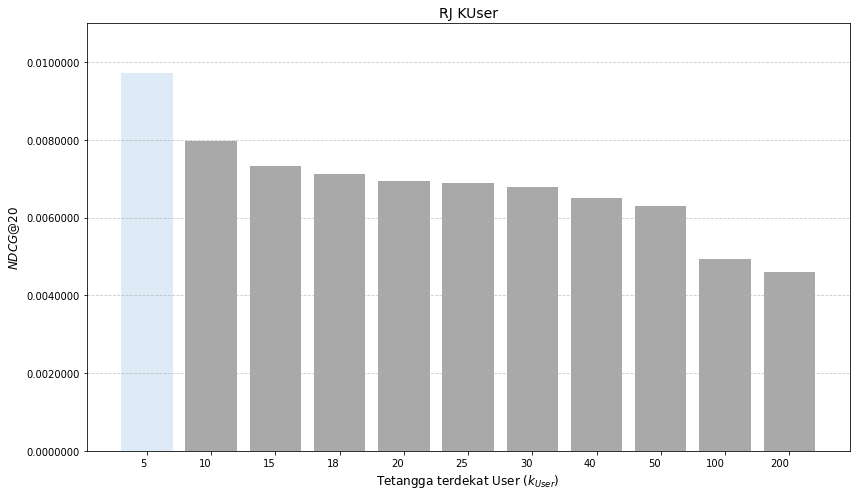

Diagram batang telah dibuat dan disimpan sebagai 'RJ KUser.png'


In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.ticker as mticker

# # Data yang diberikan
# x_labels_numeric = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
# ndcg_values = [0.00972, 0.00798, 0.00732, 0.00712, 0.00694,
#                0.00690, 0.00680, 0.00650, 0.00630, 0.00494, 0.00460]

# # Mengubah label x menjadi string untuk diagram batang kategorikal
# x_labels_str = [str(x) for x in x_labels_numeric]

# # Menentukan warna untuk setiap batang
# colors = ['#DEEAF6'] + ['#A9A9A9'] * (len(ndcg_values) - 1) # Hijau muda dan abu-abu tua

# # Membuat diagram batang
# plt.figure(figsize=(12, 7)) # Ukuran gambar bisa disesuaikan
# bars = plt.bar(x_labels_str, ndcg_values, color=colors)

# # Menambahkan label pada sumbu x dan y
# plt.xlabel('Tetangga terdekat User ($k_{User}$)', fontsize=12)
# plt.ylabel('$NDCG@20$', fontsize=12)

# # Menambahkan judul diagram (opsional, tapi disarankan)
# plt.title('RJ KUser', fontsize=14)

# # Mengatur batas sumbu y agar sesuai dengan gambar contoh (0 hingga 0.018)
# plt.ylim(0, 0.011)

# # Mengatur format angka pada sumbu y
# formatter = mticker.FormatStrFormatter('%.7f')
# plt.gca().yaxis.set_major_formatter(formatter)

# # Menambahkan grid untuk memudahkan pembacaan (opsional)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Memastikan semua label terbaca dan tidak tumpang tindih
# plt.xticks(rotation=0, ha="right") # Rotasi label sumbu x jika perlu
# plt.tight_layout() # Menyesuaikan layout agar semua elemen pas

# # Menyimpan gambar
# plt.savefig('RJ KUser.png')

# # Menampilkan diagram
# plt.show()

# print("Diagram batang telah dibuat dan disimpan sebagai 'RJ KUser.png'")

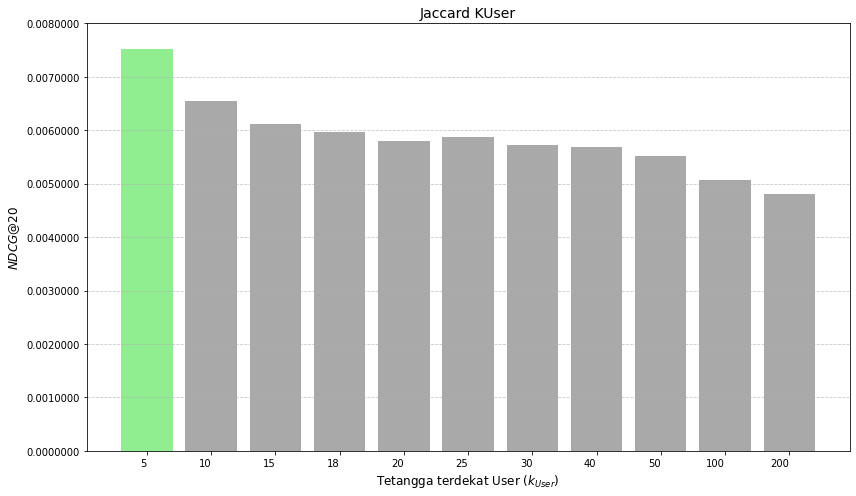

Diagram batang telah dibuat dan disimpan sebagai 'Jaccard KUser.png'


In [ ]:
# # Data yang diberikan
# x_labels_numeric = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
# ndcg_values = [0.00752, 0.00654, 0.00612, 0.00596, 0.00580, 0.00588, 0.00572, 0.00568, 0.00552, 0.00506, 0.00480]

# # Mengubah label x menjadi string untuk diagram batang kategorikal
# x_labels_str = [str(x) for x in x_labels_numeric]

# # Menentukan warna untuk setiap batang
# colors = ['#90EE90'] + ['#A9A9A9'] * (len(ndcg_values) - 1) # Hijau muda dan abu-abu tua

# # Membuat diagram batang
# plt.figure(figsize=(12, 7)) # Ukuran gambar bisa disesuaikan
# bars = plt.bar(x_labels_str, ndcg_values, color=colors)

# # Menambahkan label pada sumbu x dan y
# plt.xlabel('Tetangga terdekat User ($k_{User}$)', fontsize=12)
# plt.ylabel('$NDCG@20$', fontsize=12)

# # Menambahkan judul diagram (opsional, tapi disarankan)
# plt.title('Jaccard KUser', fontsize=14)

# # Mengatur batas sumbu y agar sesuai dengan gambar contoh (0 hingga 0.018)
# plt.ylim(0, 0.008)

# # Mengatur format angka pada sumbu y
# formatter = mticker.FormatStrFormatter('%.7f')
# plt.gca().yaxis.set_major_formatter(formatter)

# # Menambahkan grid untuk memudahkan pembacaan (opsional)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Memastikan semua label terbaca dan tidak tumpang tindih
# plt.xticks(rotation=0, ha="right") # Rotasi label sumbu x jika perlu
# plt.tight_layout() # Menyesuaikan layout agar semua elemen pas

# # Menyimpan gambar
# plt.savefig('Jaccard KUser.png')

# # Menampilkan diagram
# plt.show()

# print("Diagram batang telah dibuat dan disimpan sebagai 'Jaccard KUser.png'")

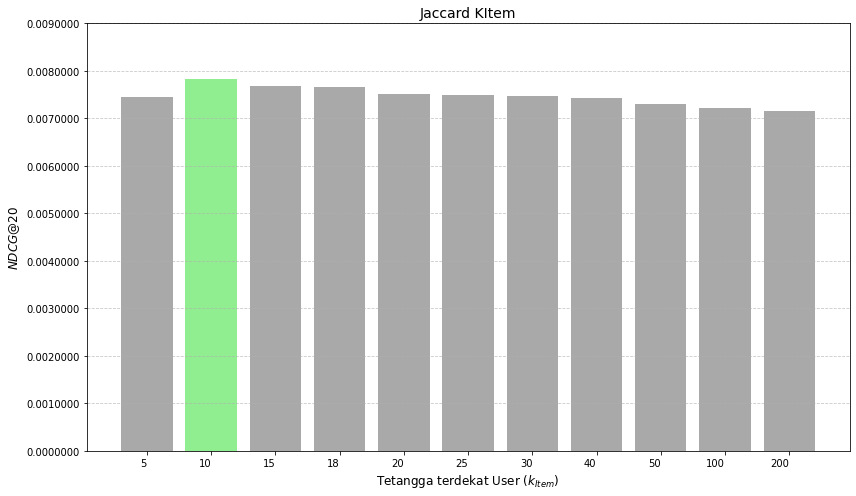

Diagram batang telah dibuat dan disimpan sebagai 'Jaccard KItem.png'


In [109]:
# Data yang diberikan
x_labels_numeric = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
ndcg_values = [
    0.00746,  # 5
    0.00782,  # 10
    0.00768,  # 15
    0.00766,  # 18
    0.00752,  # 20
    0.00750,  # 25
    0.00748,  # 30
    0.00742,  # 40
    0.00730,  # 50
    0.00722,  # 100
    0.00716   # 200
]


# Mengubah label x menjadi string untuk diagram batang kategorikal
x_labels_str = [str(x) for x in x_labels_numeric]

# Menentukan warna untuk setiap batang
max_index = ndcg_values.index(max(ndcg_values))
colors = ['#90EE90' if i == max_index else '#A9A9A9' for i in range(len(ndcg_values))]


# Membuat diagram batang
plt.figure(figsize=(12, 7)) # Ukuran gambar bisa disesuaikan
bars = plt.bar(x_labels_str, ndcg_values, color=colors)

# Menambahkan label pada sumbu x dan y
plt.xlabel('Tetangga terdekat User ($k_{Item}$)', fontsize=12)
plt.ylabel('$NDCG@20$', fontsize=12)

# Menambahkan judul diagram (opsional, tapi disarankan)
plt.title('Jaccard KItem', fontsize=14)

# Mengatur batas sumbu y agar sesuai dengan gambar contoh (0 hingga 0.018)
plt.ylim(0, 0.009)

# Mengatur format angka pada sumbu y
formatter = mticker.FormatStrFormatter('%.7f')
plt.gca().yaxis.set_major_formatter(formatter)

# Menambahkan grid untuk memudahkan pembacaan (opsional)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Memastikan semua label terbaca dan tidak tumpang tindih
plt.xticks(rotation=0, ha="right") # Rotasi label sumbu x jika perlu
plt.tight_layout() # Menyesuaikan layout agar semua elemen pas

# Menyimpan gambar
plt.savefig('Jaccard KItem.png')

# Menampilkan diagram
plt.show()

print("Diagram batang telah dibuat dan disimpan sebagai 'Jaccard KItem.png'")

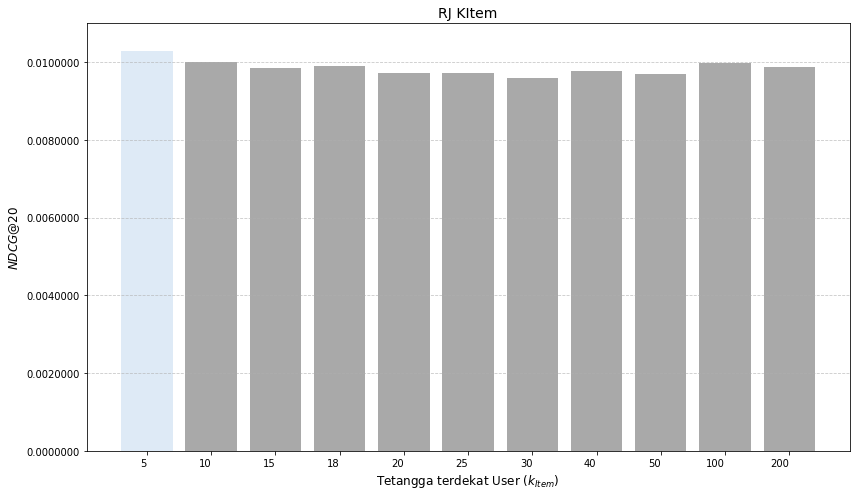

Diagram batang telah dibuat dan disimpan sebagai 'RJ KItem.png'


In [ ]:
# Data yang diberikan
x_labels_numeric = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
# ndcg_values = [
#     0.01028,  # 5
#     0.01000,  # 10
#     0.00984,  # 15
#     0.00990,  # 18
#     0.00972,  # 20
#     0.00972,  # 25
#     0.00960,  # 30
#     0.00978,  # 40
#     0.00970,  # 50
#     0.00998,  # 100
#     0.00988   # 200
# ]

ndcg_values = [
    0.00848,  # 5
    0.00858,  # 10
    0.00842,  # 15
    0.00822,  # 18
    0.00862,  # 20
    0.00900,  # 25
    0.00954,  # 30
    0.01028,  # 40
    0.01096,  # 50
    0.01228,  # 100
    0.01314   # 200
]



# Mengubah label x menjadi string untuk diagram batang kategorikal
x_labels_str = [str(x) for x in x_labels_numeric]

# Menentukan warna untuk setiap batang
max_index = ndcg_values.index(max(ndcg_values))
colors = ['#DEEAF6' if i == max_index else '#A9A9A9' for i in range(len(ndcg_values))]


# Membuat diagram batang
plt.figure(figsize=(12, 7)) # Ukuran gambar bisa disesuaikan
bars = plt.bar(x_labels_str, ndcg_values, color=colors)

# Menambahkan label pada sumbu x dan y
plt.xlabel('Tetangga terdekat User ($k_{Item}$)', fontsize=12)
plt.ylabel('$NDCG@20$', fontsize=12)

# Menambahkan judul diagram (opsional, tapi disarankan)
plt.title('RJ KItem', fontsize=14)

# Mengatur batas sumbu y agar sesuai dengan gambar contoh (0 hingga 0.018)
plt.ylim(0, 0.011)

# Mengatur format angka pada sumbu y
formatter = mticker.FormatStrFormatter('%.7f')
plt.gca().yaxis.set_major_formatter(formatter)

# Menambahkan grid untuk memudahkan pembacaan (opsional)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Memastikan semua label terbaca dan tidak tumpang tindih
plt.xticks(rotation=0, ha="right") # Rotasi label sumbu x jika perlu
plt.tight_layout() # Menyesuaikan layout agar semua elemen pas

# Menyimpan gambar
plt.savefig('RJ KItem.png')

# Menampilkan diagram
plt.show()

print("Diagram batang telah dibuat dan disimpan sebagai 'RJ KItem.png'")

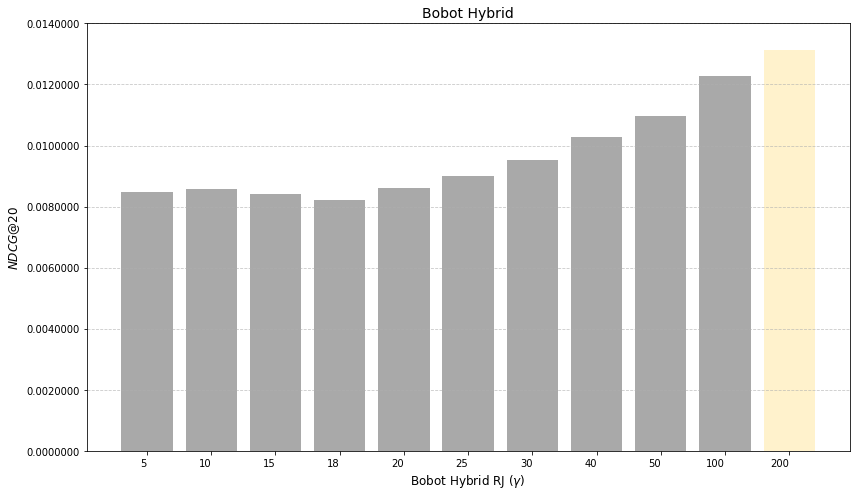

Diagram batang telah dibuat dan disimpan sebagai 'Bobot Hybrid RJ.png'


In [128]:
# Data yang diberikan
x_labels_numeric = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
ndcg_values = [
    0.00848,  # 5
    0.00858,  # 10
    0.00842,  # 15
    0.00822,  # 18
    0.00862,  # 20
    0.00900,  # 25
    0.00954,  # 30
    0.01028,  # 40
    0.01096,  # 50
    0.01228,  # 100
    0.01314   # 200
]



# Mengubah label x menjadi string untuk diagram batang kategorikal
x_labels_str = [str(x) for x in x_labels_numeric]

# Menentukan warna untuk setiap batang
max_index = ndcg_values.index(max(ndcg_values))
colors = ['#FFF2CC' if i == max_index else '#A9A9A9' for i in range(len(ndcg_values))]


# Membuat diagram batang
plt.figure(figsize=(12, 7)) # Ukuran gambar bisa disesuaikan
bars = plt.bar(x_labels_str, ndcg_values, color=colors)

# Menambahkan label pada sumbu x dan y
plt.xlabel('Bobot Hybrid RJ ($\gamma$)', fontsize=12)
plt.ylabel('$NDCG@20$', fontsize=12)

# Menambahkan judul diagram (opsional, tapi disarankan)
plt.title('Bobot Hybrid', fontsize=14)

# Mengatur batas sumbu y agar sesuai dengan gambar contoh (0 hingga 0.018)
plt.ylim(0, 0.014)

# Mengatur format angka pada sumbu y
formatter = mticker.FormatStrFormatter('%.7f')
plt.gca().yaxis.set_major_formatter(formatter)

# Menambahkan grid untuk memudahkan pembacaan (opsional)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Memastikan semua label terbaca dan tidak tumpang tindih
plt.xticks(rotation=0, ha="right") # Rotasi label sumbu x jika perlu
plt.tight_layout() # Menyesuaikan layout agar semua elemen pas

# Menyimpan gambar
plt.savefig('Bobot Hybrid RJ.png')

# Menampilkan diagram
plt.show()

print("Diagram batang telah dibuat dan disimpan sebagai 'Bobot Hybrid RJ.png'")

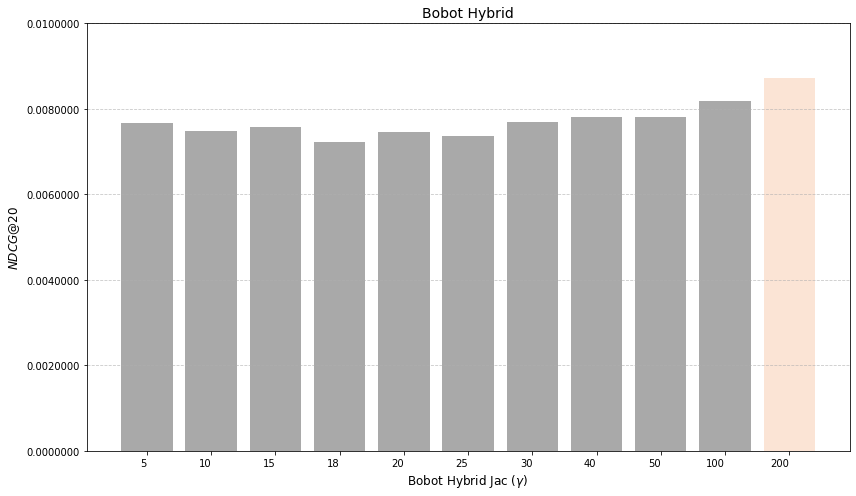

Diagram batang telah dibuat dan disimpan sebagai 'Bobot Hybrid Jac.png'


In [131]:
# Data yang diberikan
x_labels_numeric = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
ndcg_values = [
    0.00766,  # 5
    0.00748,  # 10
    0.00758,  # 15
    0.00722,  # 18
    0.00746,  # 20
    0.00736,  # 25
    0.00770,  # 30
    0.00782,  # 40
    0.00782,  # 50
    0.00818,  # 100
    0.00872   # 200
]



# Mengubah label x menjadi string untuk diagram batang kategorikal
x_labels_str = [str(x) for x in x_labels_numeric]

# Menentukan warna untuk setiap batang
max_index = ndcg_values.index(max(ndcg_values))
colors = ['#FBE4D5' if i == max_index else '#A9A9A9' for i in range(len(ndcg_values))]


# Membuat diagram batang
plt.figure(figsize=(12, 7)) # Ukuran gambar bisa disesuaikan
bars = plt.bar(x_labels_str, ndcg_values, color=colors)

# Menambahkan label pada sumbu x dan y
plt.xlabel('Bobot Hybrid Jac ($\gamma$)', fontsize=12)
plt.ylabel('$NDCG@20$', fontsize=12)

# Menambahkan judul diagram (opsional, tapi disarankan)
plt.title('Bobot Hybrid', fontsize=14)

# Mengatur batas sumbu y agar sesuai dengan gambar contoh (0 hingga 0.018)
plt.ylim(0, 0.010)

# Mengatur format angka pada sumbu y
formatter = mticker.FormatStrFormatter('%.7f')
plt.gca().yaxis.set_major_formatter(formatter)

# Menambahkan grid untuk memudahkan pembacaan (opsional)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Memastikan semua label terbaca dan tidak tumpang tindih
plt.xticks(rotation=0, ha="right") # Rotasi label sumbu x jika perlu
plt.tight_layout() # Menyesuaikan layout agar semua elemen pas

# Menyimpan gambar
plt.savefig('Bobot Hybrid Jac.png')

# Menampilkan diagram
plt.show()

print("Diagram batang telah dibuat dan disimpan sebagai 'Bobot Hybrid Jac.png'")